## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.simplefilter('ignore')

from wordcloud import WordCloud, STOPWORDS

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading the dataset

In [3]:
credits = pd.read_csv('/content/drive/MyDrive/8. Recommendation System/credits.csv',
                      error_bad_lines = False, engine = 'python')
keywords = pd.read_csv('/content/drive/MyDrive/8. Recommendation System/keywords.csv', 
                       error_bad_lines = False, engine = 'python')
links = pd.read_csv('/content/drive/MyDrive/8. Recommendation System/links.csv')
links_small = pd.read_csv('/content/drive/MyDrive/8. Recommendation System/links_small.csv')
movies = pd.read_csv('/content/drive/MyDrive/8. Recommendation System/movies_metadata.csv',
                     error_bad_lines = False, engine = 'python')
ratings = pd.read_csv('/content/drive/MyDrive/8. Recommendation System/ratings_small.csv')

## Data Cleaning

### Movies Metadata

In [4]:
movies.head(4)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0


In [5]:
movies['belongs_to_collection'][0]

"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}"

In [6]:
movies.shape

(45466, 24)

In [7]:
movies.columns # column present in the movies metadata

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [8]:
# dropping all the unwanted columns

movies.drop(columns = ['belongs_to_collection', 'homepage', 'spoken_languages',
                       'poster_path', 'production_countries','status', 'title', 'video'],
                        axis = 1, inplace = True)

In [9]:
movies.isna().sum() # checking the number of nan values in the dataset

adult                       0
budget                      0
genres                      0
id                          0
imdb_id                    17
original_language          11
original_title              0
overview                  954
popularity                  5
production_companies        3
release_date               87
revenue                     6
runtime                   263
tagline                 25054
vote_average                6
vote_count                  6
dtype: int64

#### Genre

We can use `json` library to parse the dictionary that is represented as a string in the Genre column

In [10]:
cleaned_genre = [] # list to store the final genre
for item1 in movies['genres']: # iterating through all the values in genre

# since json cannot parse values in single quotes
# we are replacing single quotes to double quotes
    new_item = item1.replace("'", "\"") 
    json_item = json.loads(new_item) # coverting the string to json 
    movie_genre = [] # list to store all the genres of the current movie
    for item2 in json_item: # iterating through the json 
        movie_genre.append(item2['name']) # getting the name of genre and appending it to movie_genre
    cleaned_genre.append(movie_genre) # appending all the genre of the current movie to cleaned genre
cleaned_genre[:5]

[['Animation', 'Comedy', 'Family'],
 ['Adventure', 'Fantasy', 'Family'],
 ['Romance', 'Comedy'],
 ['Comedy', 'Drama', 'Romance'],
 ['Comedy']]

In [11]:
# updating genres column with values in new_genre 
# adding the cleaned_genre list to the movies dataframe

movies['genres'] = cleaned_genre 
movies.head(3)

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,tagline,vote_average,vote_count
0,False,30000000,"[Animation, Comedy, Family]",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",1995-10-30,373554033.0,81.0,NaN,7.7,5415.0
1,False,65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",1995-12-15,262797249.0,104.0,Roll the dice and unleash the excitement!,6.9,2413.0
2,False,0,"[Romance, Comedy]",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",1995-12-22,0.0,101.0,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0


### Wordcloud for Genres

In [12]:
# concatenating all the genres

all_genre = ''
for genre in movies['genres']:
    all_genre += ' '.join(genre)+ ' '

stopwords = set(STOPWORDS)

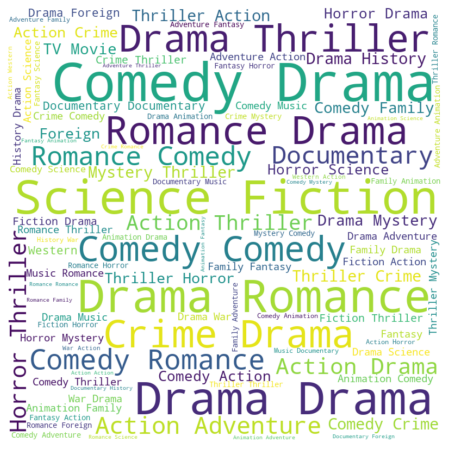

In [13]:
# plotting the wordcloud

word_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(all_genre)

plt.figure(figsize = (8, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Language

We can use the `original_languages` column to get the language of the respective movies

In [14]:
movies['original_language'].unique()

array(['en', 'fr', 'zh', 'it', 'fa', 'nl', 'de', 'cn', 'ar', 'es', 'ru',
       'sv', 'ja', 'ko', 'sr', 'bn', 'he', 'pt', 'wo', 'ro', 'hu', 'cy',
       'vi', 'cs', 'da', 'no', 'nb', 'pl', 'el', 'sh', 'xx', 'mk', 'bo',
       'ca', 'fi', 'th', 'sk', 'bs', 'hi', 'tr', 'is', 'ps', 'ab', 'eo',
       'ka', 'mn', 'bm', 'zu', 'uk', 'af', 'la', 'et', 'ku', 'fy', 'lv',
       'ta', 'sl', 'tl', 'ur', 'rw', 'id', 'bg', 'mr', 'lt', 'kk', 'ms',
       'sq', nan, '104.0', 'qu', 'te', 'am', 'jv', 'tg', 'ml', 'hr', 'lo',
       'ay', 'kn', 'eu', 'ne', 'pa', 'ky', 'gl', '68.0', 'uz', 'sm', 'mt',
       '82.0', 'hy', 'iu', 'lb', 'si'], dtype=object)

* We can see that there are integer values present in the language column.
* Let's take a look at it.

In [15]:
movies[(movies['original_language'] == '82.0') | (movies['original_language'] == '68.0')| (movies['original_language'] == '104.0')]

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,tagline,vote_average,vote_count
19730,- Written by Ørnås,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[Carousel Productions, Vision View Entertainme...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,False,1,NaN,NaN,None,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[Aniplex, GoHands, BROSTA TV, Mardock Scramble...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,False,12,NaN,NaN,None,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[Odyssey Media, Pulser Productions, Rogue Stat...",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Beware Of Frost Bites,False,22,NaN,NaN,None,NaN,NaN


* We can see that for the above listed movies important feature like reveue, runtime, vote_average,vote_count
are nan values. 
* So we can drop these rows for our analysis.

In [16]:
# getting the index values of the irregular data present in original_language
idx_to_drop = movies[(movies['original_language'] == '82.0') | (movies['original_language'] == '68.0')| (movies['original_language'] == '104.0')].index

movies.drop(index = idx_to_drop, inplace = True)

In [17]:
movies[movies['original_language'].isna()] # nan values present in original_language

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,tagline,vote_average,vote_count
19574,False,0,[Documentary],283101,tt0429086,NaN,Shadowing the Third Man,Documentary about the production of The Third ...,0.017007,"[{'name': 'StudioCanal', 'id': 694}, {'name': ...",2004-10-11,0.0,95.0,NaN,0.0,0.0
21602,False,0,"[Romance, Drama]",103902,tt0838231,NaN,Unfinished Sky,An Outback farmer takes in an Afghani woman wh...,0.359818,"[{'name': 'New Holland Pictures', 'id': 10229}...",2007-08-04,0.0,94.0,NaN,6.4,8.0
22832,False,0,"[War, Western]",359195,tt0053558,NaN,13 Fighting Men,A group of Union Army soldiers is charged with...,0.070647,"[{'name': 'Associated Producers (API)', 'id': ...",1960-03-31,0.0,69.0,NaN,0.0,0.0
32141,False,0,[Comedy],147050,tt0122580,NaN,Lambchops,George and Gracie enter an elegant drawing roo...,0.073418,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",1929-10-31,0.0,8.0,NaN,6.5,2.0
37407,False,0,[Animation],257095,tt0225145,NaN,Bajaja,The first fairy tale transformed into a full-l...,0.036841,"[{'name': 'Ceskoslovenský Státní Film', 'id': ...",1950-01-26,0.0,87.0,NaN,5.0,1.0
41047,False,0,[Documentary],332742,tt4432912,NaN,Song of Lahore,"Until the late 1970s, the Pakistani city of La...",0.373688,[],2015-11-13,0.0,82.0,NaN,6.5,2.0
41872,False,0,[Documentary],144410,tt0154152,NaN,Annabelle Serpentine Dance,Two dancers perform in succession facing a sta...,1.58434,"[{'name': 'Edison Manufacturing Company', 'id'...",1895-04-01,0.0,1.0,NaN,5.7,20.0
44057,False,0,[Drama],380438,tt0298411,NaN,Lettre d'une inconnue,NaN,0.001283,[],2001-01-01,0.0,0.0,NaN,0.0,0.0
44410,False,0,"[Animation, Documentary]",381096,tt5333518,NaN,Garn,The traditional crafts of crochet and knitting...,0.067624,[],2016-03-12,0.0,76.0,NaN,0.0,0.0
44576,False,0,[],381525,tt5376720,NaN,WiNWiN,American investment fund buys Austrian compani...,0.030766,[],2016-01-27,0.0,84.0,NaN,0.0,0.0


Since these rows does not have values that affect our analysis we can drop those rows from the dataframe.

In [18]:
movies.dropna(subset = ['original_language'], inplace = True) # dropping the nan values

Resources for finding the language codes
* https://www.fincher.org/Utilities/CountryLanguageList.shtml
* https://www.loc.gov/standards/iso639-2/php/code_list.php
* https://docs.oracle.com/cd/E13214_01/wli/docs92/xref/xqisocodes.html

In [19]:
# dictionary to map the languages

language_mapper = {'en' : 'English', 'fr' : 'French', 'zh' : 'Chinese', 'it' : 'Italian', 'fa' : 'Farsi',
                   'nl' : 'Dutch', 'de' : 'German', 'cn' : 'Chinese','ar' : 'Arabic', 'es' : 'Spanish', 
                   'ru' : 'Russian', 'sv' : 'Swedish', 'ja' : 'Japanese', 'ko' : 'Korean', 'sr' : 'Serbian', 
                   'bn' : 'Bengali', 'he' : 'Hebrew', 'pt' : 'Portuguese', 'wo' : 'Wolof', 'ro' : 'Romanian', 
                   'hu' : 'Hungarian', 'cy' : 'Welsh', 'vi' : 'Vietnamese', 'cs' : 'Czech', 'da' : 'Danish',
                   'no' : 'Norwegian', 'nb' : 'Norwegian', 'pl' : 'Polish', 'el' : 'Greek', 'sh' : 'Serbo-Croatian',
                   'mk' : 'Macedonian', 'bo' : 'Tibetan', 'ca' : 'Catalan', 'fi' : 'Finnish', 'th' : 'Thai',
                   'sk' : 'Slovak', 'bs' : 'Bosnian', 'hi' : 'Hindi', 'tr' : 'Turkish', 'is' : 'Icelandic', 
                   'ps' : 'Pashto', 'ab' : 'Abkhazian','eo' : 'Esperanto','ka' : 'Georgian', 'mn' : 'Mongolian',
                   'bm' : 'Bambara', 'zu' : 'Zulu', 'uk' : 'Ukrainian', 'af' : 'Afrikaans', 'la' : 'Latin',
                   'et' : 'Estonian', 'ku' : 'Kurdish', 'fy' : 'Frisian', 'lv' : 'Latvian', 'ta' : 'Tamil',
                   'sl' : 'Slovenian', 'tl' : 'Tagalog', 'ur' : 'Urdu', 'rw' : 'Kinyarwanda', 'id' : 'Indonesian', 
                   'bg' : 'Bulgarian', 'mr' : 'Marathi', 'lt' : 'Lithuanian', 'kk' : 'Kazakh', 'ms' : 'Malay',
                   'sq' : 'Albanian', 'qu' : 'Quechua', 'te' : 'Telugu', 'am' : 'Amharic', 'jv' : 'Javanese',
                   'tg' : 'Tajik', 'ml' : 'Malayalam','hr' : 'Croatian', 'lo' : 'Laothian', 'ay' : 'Aymara',
                   'kn' : 'Kannada', 'eu' : 'Basque', 'ne' : 'Nepali', 'pa' : 'Punjabi', 'ky' : 'Kirghiz', 
                   'gl' : 'Galician', 'uz' : 'Uzbek', 'sm' : 'Samoan', 'mt' : 'Maltese', 'hy' : 'Armenian',
                   'iu' : 'Inuktitut', 'lb' : 'Luxembourgish', 'si' : 'Sinhalese'

}

# using map function to map the correct values
movies['original_language'] = movies['original_language'].map(language_mapper)

#### Release Year

We can use the `release_date` column to get the year of release for all the movies.

In [20]:
movies['release_date'][:5]

0    1995-10-30
1    1995-12-15
2    1995-12-22
3    1995-12-22
4    1995-02-10
Name: release_date, dtype: object

In [21]:
movies[movies['release_date'].isna()]['release_date'].unique() # unique na values in release_date column

array([nan, None], dtype=object)

We can see that there are nan and None values in the column

In [22]:
movies[movies['release_date'].isna()] # nan values in release_date column

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,tagline,vote_average,vote_count
711,False,0,[],365371,tt0114894,English,War Stories Our Mother Never Told Us,Seven New Zealand women speak about their live...,0.005625,[],NaN,0.0,95.0,NaN,0.0,0.0
734,False,0,[],215107,tt0105737,English,Vermont Is for Lovers,Vermont is for Lovers is an independently prod...,0.75,[],NaN,0.0,88.0,NaN,0.0,0.0
3460,False,0,[Drama],94214,tt0210130,English,"Jails, Hospitals & Hip-Hop","Jails, Hospitals &amp; Hip-Hop is a cinematic ...",0.009057,[],NaN,10.0,90.0,three worlds / two million voices / one genera...,0.0,0.0
3628,False,0,[],207731,tt0217287,English,Boricua's Bond,"Tommy, a talented Puerto Rican painter living ...",0.035352,[],NaN,0.0,105.0,NaN,2.0,1.0
5879,False,0,"[Drama, Romance, Foreign]",99885,tt0979876,English,Divine Intervention,Four friends fight an insane man's crusade to ...,0.001181,[],NaN,0.0,87.0,His Judgement Cometh...,0.0,0.0
13839,False,750000,[],91205,tt0775434,English,Bling: A Planet Rock,Bling is a documentary film which focuses on t...,0.0,[],NaN,0.0,90.0,The blood diamond & hip-hop,0.0,0.0
14801,False,0,[],281287,tt0104060,English,Dead Ahead: The Exxon Valdez Disaster,The real-life struggle to contain the environm...,0.035294,[],NaN,0.0,0.0,NaN,5.0,1.0
16836,False,0,[],442417,tt1189042,English,Das Experiment 770 - Gebären auf Befehl,52min | Documentary | TV Movie 12 January 2005,0.0,[],NaN,0.0,52.0,NaN,0.0,0.0
16953,False,0,[],367647,tt0078588,English,Connections,Documentary Follow James Burke through the hi...,0.035294,[],NaN,0.0,0.0,NaN,9.0,1.0
17339,False,0,[Documentary],366044,tt1348997,English,Menschliches Versagen,"Using first-hand accounts, award-winning filmm...",0.294095,[],NaN,0.0,91.0,NaN,0.0,0.0


Since the above movies also have 0 for important features like reveue, runtime, vote_average,vote_count we can drop those rows.

In [23]:
# dropping the nan values present in release_date column

movies.dropna(subset = ['release_date'], inplace = True) 

In [24]:
# we can use the split method by passing '-' as parameter and getting the first element to get the year 
# also changing the datatype of the year value to int

movies['release_year'] = movies['release_date'].apply(lambda x:int(x.split('-')[0]))
movies['release_year'].head(3)

0    1995
1    1995
2    1995
Name: release_year, dtype: int64

#### Runtime

In [25]:
movies['runtime'].unique()

array([8.100e+01, 1.040e+02, 1.010e+02, 1.270e+02, 1.060e+02, 1.700e+02,
       9.700e+01, 1.300e+02, 8.800e+01, 7.800e+01, 1.920e+02, 1.190e+02,
       1.780e+02, 1.360e+02, 9.800e+01, 9.000e+01, 1.030e+02, 1.050e+02,
       1.240e+02, 1.320e+02, 1.110e+02, 1.120e+02, 1.230e+02, 1.000e+02,
       1.080e+02, 9.900e+01, 1.290e+02, 5.000e+01, 8.900e+01, 1.210e+02,
       1.220e+02, 5.100e+01, 1.170e+02, 1.160e+02, 9.600e+01, 9.300e+01,
       9.500e+01, 1.150e+02, 1.370e+02, 9.200e+01, 8.500e+01, 9.100e+01,
       1.750e+02, 8.700e+01, 7.000e+01, 1.180e+02, 1.020e+02, 1.350e+02,
       1.100e+02, 1.770e+02, 1.140e+02, 1.130e+02, 8.600e+01, 1.250e+02,
       1.400e+02, 1.390e+02, 8.200e+01, 8.300e+01, 1.280e+02, 1.090e+02,
       8.000e+01, 1.340e+02, 1.070e+02, 9.400e+01, 1.450e+02, 7.300e+01,
       0.000e+00, 7.700e+01, 1.710e+02, 1.330e+02, 1.540e+02, 1.620e+02,
       1.420e+02, 1.260e+02, 1.410e+02, 1.800e+02, 1.910e+02, 6.100e+01,
       8.400e+01, 1.440e+02, 1.310e+02, 1.380e+02, 

* We can see that there a values less than 15 for runtime which is not possible.
* Lets take a look at it.

In [26]:
movies[movies['runtime'] <= 15].shape

(2408, 17)

* We can see that there are 2408 movies that have runtime <= 15 minutes.
* We can replace those values with the median value of runtime.

In [27]:
median_runtime = movies['runtime'].median() # getting the median value of runtime

# replacing runtime less than 10 with median value
movies['runtime'] = movies['runtime'].replace(list(range(0, 16)), median_runtime) 

In [28]:
# dropping the nan values in the runtime column  

movies.dropna(subset = ['runtime'], inplace = True)

#### Weighted Ratings

We can use the weighted rating formula provided by IMDB.

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,
* *v* is the number of votes for the movie
* *m* is the minimum votes required to be listed in the chart
* *R* is the average rating of the movie
* *C* is the mean vote across the whole report


In [29]:
vote_count_avg = movies['vote_count'].mean() # average of vote_count column
vote_average = movies['vote_average'] 
vote_count = movies['vote_count']

In [30]:
C = vote_average.mean() # getting the mean value of vote_average
m = vote_count.quantile(.95) # 95th percentile value of vote_count
print(C)
print(m)

5.635069482922644
437.09999999999854


In [31]:
# getting the rows where vote_count is greater than m

filtered_movies_df = movies[movies['vote_count'] >= m][['original_title', 'release_year', 'vote_count', 'vote_average', 'popularity', 'genres']]
filtered_movies_df.shape

(2256, 6)

In [32]:
#create a function for weighted rating score based off count of reviews

def weighted_rating(data):
    v = data['vote_count']
    R = data['vote_average']

    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [33]:
# applying the function on the newly created column weighted_rating
filtered_movies_df['weighted_rating'] = filtered_movies_df.apply(weighted_rating, axis = 1)
filtered_movies_df['weighted_rating'] = round(filtered_movies_df['weighted_rating'], 2)
filtered_movies_df['weighted_rating'].head()

0     7.55
1     6.71
5     7.31
9     6.34
15    7.27
Name: weighted_rating, dtype: float64

In [34]:
# top 10 movies w.r.t weighted_rating
filtered_movies_df.sort_values(by = 'weighted_rating', ascending = False).head(10)

,original_title,release_year,vote_count,vote_average,popularity,genres,weighted_rating
314,The Shawshank Redemption,1994,8358.0,8.5,51.645403,"[Drama, Crime]",8.36
834,The Godfather,1972,6024.0,8.5,41.109264,"[Drama, Crime]",8.31
12481,The Dark Knight,2008,12269.0,8.3,123.167259,"[Drama, Action, Crime, Thriller]",8.21
2843,Fight Club,1999,9678.0,8.3,63.869599,[Drama],8.18
292,Pulp Fiction,1994,8670.0,8.3,140.950236,"[Thriller, Crime]",8.17
351,Forrest Gump,1994,8147.0,8.2,48.307194,"[Comedy, Drama, Romance]",8.07
23673,Whiplash,2014,4376.0,8.3,64.29999,[Drama],8.06
522,Schindler's List,1993,4436.0,8.3,41.725123,"[Drama, History, War]",8.06
5481,千と千尋の神隠し,2001,3968.0,8.3,41.048867,"[Fantasy, Adventure, Animation, Family]",8.04
15480,Inception,2010,14075.0,8.1,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",8.03


#### Production companies

In [35]:
cleaned_prod = [] # list to store the final genre
for item1 in movies['production_companies']: # iterating through all the values in genre
    try:
# since json cannot parse values in single quotes
# we are replacing single quotes to double quotes
        new_item = item1.replace("'", "\"") 
        json_item = json.loads(new_item) # coverting the string to json 
        movie_prod = [] # list to store all the genres of the current movie
        for item2 in json_item: # iterating through the json 
            movie_prod.append(item2['name']) # getting the name of genre and appending it to movie_genre
        cleaned_prod.append(movie_prod) # appending all the genre of the current movie to cleaned genre
    except:
        cleaned_prod.append([])
cleaned_prod[:5]

[['Pixar Animation Studios'],
 ['TriStar Pictures', 'Teitler Film', 'Interscope Communications'],
 ['Warner Bros.', 'Lancaster Gate'],
 ['Twentieth Century Fox Film Corporation'],
 ['Sandollar Productions', 'Touchstone Pictures']]

In [36]:
# replacing the values in production_companies
# with cleaned_prod 

movies['production_companies'] = cleaned_prod
movies.head(3)

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,tagline,vote_average,vote_count,release_year
0,False,30000000,"[Animation, Comedy, Family]",862,tt0114709,English,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],1995-10-30,373554033.0,81.0,NaN,7.7,5415.0,1995
1,False,65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,English,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",1995-12-15,262797249.0,104.0,Roll the dice and unleash the excitement!,6.9,2413.0,1995
2,False,0,"[Romance, Comedy]",15602,tt0113228,English,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[Warner Bros., Lancaster Gate]",1995-12-22,0.0,101.0,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,1995


## Popularity Based Recommendation System
* It is a type of recommendation system which works on the principle of popularity and or anything which is in trend. These systems check about the product or movie which are in trend or are most popular among the users and directly recommend those. 
* We have used the weighted ratings feature and genre of the movies to find movies that are popular with respect to each genre and recommend them to the user. 

In [37]:
# creating duplicate rows such that all the genres for a movie are listed

new_genre = movies.apply(lambda x: pd.Series(x['genres']),axis = 1).stack().reset_index(level = 1, drop = True)
new_genre.head()

0    Animation
0       Comedy
0       Family
1    Adventure
1      Fantasy
dtype: object

In [38]:
new_genre.name = 'new_genre' # setting a name for the series
 # dropping the genre column and adding new_genre series to the dataframe
new_movies = movies.drop('genres', axis = 1).join(new_genre)
new_movies.head(4)

,adult,budget,id,imdb_id,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,tagline,vote_average,vote_count,release_year,new_genre
0,False,30000000,862,tt0114709,English,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],1995-10-30,373554033.0,81.0,NaN,7.7,5415.0,1995,Animation
0,False,30000000,862,tt0114709,English,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],1995-10-30,373554033.0,81.0,NaN,7.7,5415.0,1995,Comedy
0,False,30000000,862,tt0114709,English,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],1995-10-30,373554033.0,81.0,NaN,7.7,5415.0,1995,Family
1,False,65000000,8844,tt0113497,English,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",1995-12-15,262797249.0,104.0,Roll the dice and unleash the excitement!,6.9,2413.0,1995,Adventure


In [39]:
def get_recommendation(genre, rating = 0.70):
    data = new_movies[new_movies['new_genre'] == genre] # getting all the movies for the passed genre
    vote_count = data['vote_count']
    vote_average = data['vote_average']
    C = vote_average.mean() # mean of the vote_average
    m = vote_count.quantile(rating) # mean of vote_count

    # getting the rows where vote_count is greater than m
    filtered_data = data[data['vote_count'] >= m][['original_title', 'release_year', 'vote_count', 'vote_average',
                                                   'popularity', 'production_companies']]
    # applying the weighted rating formula for the filtered_data
    filtered_data['weighted_rating'] = filtered_data.apply(lambda x:(x['vote_count']/(x['vote_count'] + m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis = 1)
    # sorting the dataframe in w.r.t weighted_rating in descending order
    filtered_data = filtered_data.sort_values(by = 'weighted_rating', ascending = False).head(100)

    return filtered_data[['original_title', 'release_year', 'popularity', 'weighted_rating']]


In [40]:
get_recommendation('Action').head(10) # getting recommendataions for Action genre

,original_title,release_year,popularity,weighted_rating
12481,The Dark Knight,2008,123.167259,8.288561
1154,The Empire Strikes Back,1980,19.470959,8.177563
15480,Inception,2010,29.108149,8.090759
7000,The Lord of the Rings: The Return of the King,2003,29.324358,8.084230
256,Star Wars,1977,42.149697,8.080887
1910,七人の侍,1954,15.01777,8.056204
43190,Band of Brothers,2001,7.903731,8.025298
4863,The Lord of the Rings: The Fellowship of the Ring,2001,32.070725,7.985986
5814,The Lord of the Rings: The Two Towers,2002,29.423537,7.983707
4135,Scarface,1983,11.299673,7.959158


In [41]:
get_recommendation('Thriller').head(10) # getting recommendataions for Thriller genre

,original_title,release_year,popularity,weighted_rating
12481,The Dark Knight,2008,123.167259,8.286535
292,Pulp Fiction,1994,140.950236,8.280986
1176,Psycho,1960,36.826309,8.232699
289,Léon,1994,20.477329,8.163299
877,Rear Window,1954,17.911314,8.099666
15480,Inception,2010,29.108149,8.089133
46,Se7en,1995,18.45743,8.074296
586,The Silence of the Lambs,1991,4.307222,8.066681
4099,Memento,2000,15.450789,8.063680
1213,The Shining,1980,19.611589,8.061125


In [42]:
get_recommendation('Horror').head(10) # getting recommendataions for Horror genre

,original_title,release_year,popularity,weighted_rating
1176,Psycho,1960,36.826309,8.246079
1213,The Shining,1980,19.611589,8.068625
1171,Alien,1979,23.37742,7.875082
44677,Black Mirror: White Christmas,2014,24.910782,7.780321
2175,The Thing,1982,16.83125,7.733912
1158,Aliens,1986,21.761179,7.668061
39821,부산행,2016,22.685169,7.596594
1338,Jaws,1975,19.726114,7.463460
8147,Shaun of the Dead,2004,14.902948,7.461301
1888,The Exorcist,1973,12.137595,7.453280


## Content Based Recommendation
* It is a type of recommendation system, relevant items are shown using the content of the previously searched items by the users based on the attribute/tag of the movie that the user likes.  
* To get tags related to each movie we have created a new feature called “tagline” by concatenating the description and overview features of each movie. 
* We have used the concepts of Tf-Idf vectorizer and cosine similarity to build the content based recommendation systems. 

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [44]:
movies['id'] = movies['id'].astype(int) # changing the type of id col to int

# getting all the non null values in tmdbId column
# and changing their type to integer
movie_id = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype(int)

In [45]:
# getting all the rows where the id value of movies dataframe
# is present in the movie_id series

new_movies_df = movies[movies['id'].isin(movie_id)] 
new_movies_df.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,tagline,vote_average,vote_count,release_year
0,False,30000000,"[Animation, Comedy, Family]",862,tt0114709,English,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],1995-10-30,373554033.0,81.0,NaN,7.7,5415.0,1995
1,False,65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,English,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",1995-12-15,262797249.0,104.0,Roll the dice and unleash the excitement!,6.9,2413.0,1995
2,False,0,"[Romance, Comedy]",15602,tt0113228,English,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[Warner Bros., Lancaster Gate]",1995-12-22,0.0,101.0,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,1995
3,False,16000000,"[Comedy, Drama, Romance]",31357,tt0114885,English,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],1995-12-22,81452156.0,127.0,Friends are the people who let you be yourself...,6.1,34.0,1995
4,False,0,[Comedy],11862,tt0113041,English,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",1995-02-10,76578911.0,106.0,Just When His World Is Back To Normal... He's ...,5.7,173.0,1995


In [46]:
new_movies_df['tagline'] = new_movies_df['tagline'].fillna('') # filling the nan values in tagline with ''

# creating description column which is the concatenation of overview and tagline
new_movies_df['description'] = new_movies_df['overview'] + new_movies_df['tagline'] 
new_movies_df['description'] = new_movies_df['description'].fillna('') # filling the nan values in description with ''

### TF-IDF Vectorizer
It is the measure of originality of the word by comparing the number of times a word appears in the string with the number of string the word appears in.

In [47]:
# converting all the data in description
# to tf-idf matrix

tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 6), min_df = 0, stop_words = 'english')
tf_idf_matrix = tf.fit_transform(new_movies_df['description']) # creating the tf-idf matrix

In [48]:
tf_idf_matrix.shape

(9099, 1284041)

### Cosine Similarity

We can use the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's **linear_kernel** to calculate cosine_similarities since it is much faster.

In [49]:
# finding the similarities

cosine_sim = linear_kernel(tf_idf_matrix, tf_idf_matrix)
cosine_sim[0]

array([1.        , 0.00210872, 0.        , ..., 0.        , 0.00120522,
       0.        ])

In [50]:
new_movies_df = new_movies_df.reset_index() # resetting the index to get a ordered dataframe
titles = new_movies_df['original_title'] 
# creating a series using original_title column
indices = pd.Series(new_movies_df.index, index = new_movies_df['original_title'])

In [51]:
# function to get recommendation

def get_recommendation(title):
    idx = indices[title] # getting the index of the passed movie
    # creating a list of tuples with index and similarity scores for all the other movies
    sim_scores = list(enumerate(cosine_sim[idx])) 
    # sorting the similarity scores in descending order to get top similar movies
    sim_scores = sorted(sim_scores, key = lambda x:x[1], reverse = True)
    # getting the top 30 movies for the passed movies along with its index
    sim_scores = sim_scores[1:31] # starting from 1 because the element at 0th index corresponds to the passed movie
    movie_idx = [idx[0] for idx in sim_scores] # getting the indices of the top similar movies
    return titles.iloc[movie_idx]

In [52]:
get_recommendation('Saving Private Ryan').head(10)

3522                         Bat*21
6188                 The Great Raid
5273                        隠し砦の三悪人
4643      Heaven Knows, Mr. Allison
8488              The Monuments Men
2137    Μια αιωνιότητα και μια μέρα
3838             Behind Enemy Lines
3425          The Magnificent Seven
8666                           Fury
2184                   Barry Lyndon
Name: original_title, dtype: object

In [53]:
get_recommendation('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
7565                 Batman: Under the Red Hood
8227    Batman: The Dark Knight Returns, Part 2
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: original_title, dtype: object

## Collaborative Filtering

* Recommending the new items to users based on the interest and preference of other similar users is basically collaborative-based filtering.  
* This overcomes the disadvantage of content-based filtering as it will use the user Interaction instead of content from the items used by the users.  
* There are 2 types of collaborative based filtering.
 
$\;\;\;\;\;\;\;\;\;\;\;\;$ * User-Based Collaborative  filtering 

$\;\;\;\;\;\;\;\;\;\;\;\;$ * Item-Based Collaborative Filtering 

In [54]:
!pip install scikit-surprise -q

     |████████████████████████████████| 11.8 MB 4.7 MB/s 


In [55]:
# libraries used to implement coloborative filtering

from surprise import Reader, Dataset
from surprise.model_selection import cross_validate

In [56]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [57]:
# since the Reader() can take only 3 rows
# we can drop the timestamp colun

ratings.drop(columns = ['timestamp'], axis = 1, inplace = True)

# creating a new csv file without headers 
# after dropping timestamp column

ratings.to_csv('ratings_modified.csv', header = None, index = False)

In [58]:
# reading the modified ratings file

ratings_mod = pd.read_csv('ratings_modified.csv')
ratings_mod.head()

,1,31,2.5
0,1,1029,3.0
1,1,1061,3.0
2,1,1129,2.0
3,1,1172,4.0
4,1,1263,2.0


In [59]:
path = 'ratings_modified.csv' # path of the modified csv file
# calling Reader() using "user item rating" and rating scale of 1 to 5
reader = Reader(line_format = 'user item rating', sep = ',', rating_scale = (1, 5))
# loading the dataset into the surprise reader
data = Dataset.load_from_file(path, reader = reader)

In [60]:
train_data = data.build_full_trainset() # building the training data

# number of users and items in the dataset
print('The number of users in the dataset :', train_data.n_users)
print('The number of movies in the dataset :', train_data.n_items)

The number of users in the dataset : 671
The number of movies in the dataset : 9066


* Here we can see that the number of users is less than the number of items.
* So the best choice for this dataset to implement User-Based Recommendation.

In [61]:
# concatenating the year of release for each movie
# along with the title of the movies

movies['release_year'] = movies['release_year'].astype(str)
movies['original_title'] = movies['original_title'] + ' (' + movies['release_year'] + ')'

In [62]:
movies[['id','original_title']].head(3)

,id,original_title
0,862,Toy Story (1995)
1,8844,Jumanji (1995)
2,15602,Grumpier Old Men (1995)


In [63]:
ratings.head(3)

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0


* All the movies that are present in the movies metadata are not present in the ratings data.
* So we are getting only the movies which are present in both the movies data and ratings data.

In [64]:
movie_id = ratings['movieId'].unique() # all the unique movie id's in ratings data

# getting all the movie details whose movie id is present in
# both ratings and movies data
new_df = movies[movies['id'].isin(movie_id)] 
new_df['original_title'].head()

5                      Heat (1995)
9                 GoldenEye (1995)
14         Cutthroat Island (1995)
15                   Casino (1995)
16    Sense and Sensibility (1995)
Name: original_title, dtype: object

### User-Based Recommendation

* Rating of the item is done using the rating of neighboring users. 
* In simple words, It is based on the notion of users’ similarity. 

In [65]:
# using the KNNWithMeans algorithm to build the User-Based Filtering 

from surprise import KNNWithMeans

# setting similarity configurations
sim_options = {
    'name' : 'cosine', # using cosine method to find the similarities
    'user_based' : True # finding similarities between users
}

# KNN model initialization
# 15 is the number of neighbors considered for recommendation
# 5 is the minimum number of neighbors considered for recommendation
algo = KNNWithMeans(k = 15, min_k = 5,
                     sim_options = sim_options, verbose = True)

In [66]:
# performing cross validation using RMSE for accuracy calculation
# passing the initialised model and the data to perform cv
# total of 5 cv is performed on the data

results = cross_validate(algo = algo, data = data,
                         measures = ['RMSE'], cv = 5,
                         return_train_measures = True)

print('RMSE Value on the test data is :', results['test_rmse'].mean()) # mean RMSE while testing

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE Value on the test data is : 0.9220603009835108


In [67]:
algo.fit(train_data) # training the model using training data

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [68]:
# creating a dictionary with the movie id as keys and movie title as values

movie_id_to_title = {}

for m_id, m_title in zip(new_df['id'].values, new_df['original_title'].values):
    movie_id_to_title[str(m_id)] = m_title

list(movie_id_to_title.items())[:5]

[('949', 'Heat (1995)'),
 ('710', 'GoldenEye (1995)'),
 ('1408', 'Cutthroat Island (1995)'),
 ('524', 'Casino (1995)'),
 ('4584', 'Sense and Sensibility (1995)')]

In [69]:
# predicting the rating given for movie with id 949
# by the user with id 12

val = algo.predict(uid = '12', iid = '949')
print(movie_id_to_title[val[1]], val[3])

Heat (1995) 2.5731059398160454


In [70]:
from collections import defaultdict

# function to generate top predictions for each user

def get_top_n(predictions, n):
    top_n = defaultdict(list)
    # iterating through the attributes of preditions
    for uid, iid, true_r, est, _ in predictions:
        # using user id as key and movie id and predicted rating as values enclosed in a list of tuples
        top_n[uid].append((iid, est)) 
    
    for uid, user_ratings in top_n.items(): # iteratinf through the top_n dictionary
        # sorting the ratings predicted in descending order
        user_ratings.sort(key=lambda x: x[1], reverse=True) 
        top_n[uid] = user_ratings[:n] # getting the top n highly rated movies for each user
    
    return top_n

In [71]:
# building the anti train set for all the users
test_data = train_data.build_anti_testset()
predictions = algo.test(test_data) # making predictions on the test data
top_n = get_top_n(predictions, n = 50) # getting the predictions for each user

In [72]:
# funtion to get the previously watched movies by a user

def PreviousMoviedUserWatched(user_df , user_id , item_map):
    user_df = user_df[user_df.iloc[: , 0] == user_id] # getting all the data for the passsed user id

    # iterating through the movie id and rating for the movie in ratings data
    for movie_id ,rating in zip(user_df.iloc[:,1].values , user_df.iloc[:,2].values):
        # since the movie id's are inconsistent 
        # we are using try catch to get the movie details present in both ratings and item_map dictionary
        try:
            print(item_map[str(movie_id)] , rating)
        except:
            KeyError

In [73]:
# function to predict the ratings that will be given by the user 

def UserPredictions(user_id , top_n , item_map):
    print("Predictions for User Id : " , user_id)
    user_ratings = top_n[str(user_id)] # getting the ratings that are given by the user from top_n dictionary
    # iterating through the movie id and ratings in user_ratings
    for item_id , rating in user_ratings:
        try:
            print(item_map[item_id] , " : " , rating) # printing the movie id and its predicted ratings
        except:
            KeyError

In [74]:
# getting the previously wathced movies for user_id 1

PreviousMoviedUserWatched(user_df = ratings , user_id = 1, item_map = movie_id_to_title)

Rocky III (1982) 2.5
Greed (1924) 1.0
American Pie (1999) 4.0
My Tutor (1983) 2.0
Jay and Silent Bob Strike Back (2001) 2.0
Vivement dimanche! (1983) 2.5


In [75]:
# getting the predictions for user_id 1 for other movies

UserPredictions(user_id = 1, top_n = top_n , item_map = movie_id_to_title)

Predictions for User Id :  1
End of the World (1977)  :  3.774033989950933
Backdraft (1991)  :  3.589739992712326
Gegen die Wand (2004)  :  3.4935162513500058
Crank (2006)  :  3.4674735234016674
The Return of the King (1980)  :  3.416876918629672
The Wanderers (1979)  :  3.385996876234682
Laura (1944)  :  3.3778366297697406
North by Northwest (1959)  :  3.3430086265630883
Kirschblüten - Hanami (2008)  :  3.339866796821291
Snakes on a Plane (2006)  :  3.3250324165138307
Straw Dogs (1971)  :  3.3127516748177084
Die Büchse der Pandora (1929)  :  3.2930805858875907
The First Wives Club (1996)  :  3.290799322077455


### Item Based Filtering

* The rating of the item is predicted using the user’s own rating on neighboring items. 
* In simple words, it is based on the notion of item similarity. 

In [76]:
# using the KNNWithMeans algorithm to build the User-Based Filtering 

from surprise import KNNWithMeans

# setting similarity configurations
sim_options = {
    'name' : 'cosine', # using cosine method to find the similarities
    'user_based' : False # finding similarities between items
}

# KNN model initialization
# 15 is the number of neighbors considered for recommendation
# 5 is the minimum number of neighbors considered for recommendation
algo = KNNWithMeans(k = 15, min_k = 5,
                     sim_options = sim_options, verbose = True)

In [77]:
# performing cross validation using RMSE for accuracy calculation
# passing the initialised model and the data to perform cv
# total of 5 cv is performed on the data
results = cross_validate(algo = algo, data = data,
                         measures = ['RMSE'], cv = 5,
                         return_train_measures = True)

print('RMSE Value on the test data is :', results['test_rmse'].mean()) # mean RMSE while testing

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE Value on the test data is : 0.9442943553925149


In [78]:
algo.fit(train_data) # training the model using training data

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [79]:
# predicting the rating given for movie with id 949
# by the user with id 12

val = algo.predict(uid = '12', iid = '949')
print(movie_id_to_title[val[1]], val[3])

Heat (1995) 3.620375695292362


In [80]:
train_data = data.build_full_trainset() # building the training data
test_data = train_data.build_anti_testset() # building the anti train set for all the users
predictions = algo.test(test_data) # making predictions on the test data
top_n = get_top_n(predictions, n = 50) # getting the predictions for each user

In [81]:
# getting the predictions for user_id 1 for other movies

UserPredictions(user_id = 1, top_n = top_n , item_map = movie_id_to_title)

Predictions for User Id :  1
Garde à vue (1981)  :  5
Murder in Three Acts (1986)  :  5
Il giardino dei Finzi Contini (1970)  :  5
Cockpit (2012)  :  5
Singin' in the Rain (1952)  :  5
The Falcon and the Snowman (1985)  :  5
海洋天堂 (2010)  :  5
Aamdani Atthanni Kharcha Rupaiya (2001)  :  5
American Mullet (2001)  :  5
Knight Moves (1992)  :  5
Silentium (2004)  :  5
Night Without Sleep (1952)  :  5
The Pillow Book (1996)  :  5
